# Imports

In [222]:
import sys
import os

PROJECT_ROOT = os.path.abspath("..")  # ajusta según tu estructura
sys.path.append(PROJECT_ROOT)



import json
from pathlib import Path
from xml.etree.ElementInclude import include

import numpy as np
import pandas as pd
import joblib

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from database_tier1 import TARGET_STOCKS
from machine_learning.data_collectors import (
    build_ml_dataframe,
    build_supervised_dataset,
    time_split_masks,
    purged_ts_cv_splits,
    TARGET_HORIZONS,
    TARGET_LOOKBACKS,
)
from machine_learning.evaluators import eval_regression, eval_regression_extended

from python_scripts.LLM_analysis.preprocess_store_database import get_connection

In [223]:


def save_ridge_artifact(
    run_dir: str,
    pipeline,
    config: dict,
    metrics: dict,
    feature_names: list[str],
):
    p = Path(run_dir)
    p.mkdir(parents = True, exist_ok=True)

    # Complete pipeline (scaler + ridge)

    joblib.dump(pipeline, p / "pipeline.joblib")

    # Columns in order

    with open(p / "feature_names.json", "w") as f:
        json.dump(feature_names, f, indent=2)

    # Config and metrics
    with open(p / "config.json", "w") as f:
        json.dump(config, f, indent=2, default=str)

    with open(p / "metrics.json", "w") as f:
        json.dump(metrics, f, indent=2, default=float)

    # Coefficients

    if hasattr(pipeline, "names_steps") and "ridge" in pipeline.named_steps:
        ridge = pipeline.names_stemps["ridge"]
        coefs = np.asarray(ridge.coef_).ravel()
        coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
        coef_df["abs_coef"] = np.abs(coef_df["coef"])
        coef_df = coef_df.sort_values("abs_coef", ascending=False)
        coef_df.to_csv(p / "coefficients.csv", index = False)

# Parameters


In [224]:
# Build dataset
conn = get_connection()
symbols = TARGET_STOCKS

timeframe = "1Day"
lookback = TARGET_LOOKBACKS[2]
horizon = TARGET_HORIZONS[3]

include_indicators = False

include_economic_indicators = False
econ_indicator_names = ['CPI', 'UNEMPLOYMENT']

include_fmp = False
fmp_prefix = "fmp"
fmp_feature_names = []
keep_fmp_asof_date = False

base_feature_cols = ["open", "high", "low", "close", "volume", "trade_count", "vwap"]
# base_feature_cols = ["open", "high", "low", "close", "volume", "trade_count", "vwap", "UNEMPLOYMENT", "CPI"]

# Dataset generation

In [225]:
df = build_ml_dataframe(
    conn,
    symbols = symbols,
    timeframe=timeframe,
    include_indicators=include_economic_indicators,
    include_econ=include_economic_indicators,
    include_fmp=include_fmp,
    econ_indicator_names=econ_indicator_names,
)

X, y, meta = build_supervised_dataset(
    df=df,
    feature_cols=base_feature_cols,
    lookback=lookback,
    horizon=horizon,
    price_col="close",
    group_col="symbol",
    timestamp_col="timestamp",
)

train_mask, val_mask, test_mask = time_split_masks(
    meta, train_frac=0.90,
    val_frac=0.07,
    timestamp_col="timestamp",
    target_ts_col="target_timestamp",
)

# Tests
X_test = X.loc[test_mask].reset_index(drop=True)
y_test = y.loc[test_mask].reset_index(drop=True)
meta_test = meta.loc[test_mask].reset_index(drop=True)

# Train + Val
trainval_mask = train_mask | val_mask
X_tv = X.loc[trainval_mask].reset_index(drop=True)
y_tv = y.loc[trainval_mask].reset_index(drop=True)
meta_tv = meta.loc[trainval_mask].reset_index(drop=True)

print(df.columns)
print(X_tv.shape, X_test.shape)
print(df.head())

Index(['symbol', 'timestamp', 'timeframe', 'open', 'high', 'low', 'close',
       'volume', 'trade_count', 'vwap'],
      dtype='object')
(12592, 840) (4401, 840)
  symbol                 timestamp timeframe    open     high     low   close  \
0   AAPL 2018-02-26 05:00:00+00:00      1Day  176.35  179.390  176.21  178.97   
1   AAPL 2018-02-27 05:00:00+00:00      1Day  179.10  180.480  178.16  178.39   
2   AAPL 2018-02-28 05:00:00+00:00      1Day  179.26  180.615  178.05  178.12   
3   AAPL 2018-03-01 05:00:00+00:00      1Day  178.54  179.775  172.66  175.00   
4   AAPL 2018-03-02 05:00:00+00:00      1Day  172.80  176.300  172.45  176.21   

     volume  trade_count        vwap  
0  40421646       248927  178.385636  
1  40894173       259222  179.268869  
2  41392251       195754  179.247248  
3  50891879       345195  176.081558  
4  40994637       249018  174.844074  


# Model with training

In [226]:
 # 3 model plus looking for alpha
pipe = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("ridge", Ridge()),
    ]
)

# Grid
alpha_grid = np.logspace(-6, 6, 61)
param_grid = {
    "ridge__alpha": alpha_grid,   
    # "ridge__fit_intercept": [True, False] optional
}

cv_splits = purged_ts_cv_splits(meta=meta_tv, n_splits=5)

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv_splits,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    refit=True,
    verbose=1,
)

gs.fit(X_tv, y_tv)

best_pipe = gs.best_estimator_
best_alpha = float(gs.best_params_["ridge__alpha"])

Fitting 5 folds for each of 61 candidates, totalling 305 fits


# Evaluation

In [227]:
 # 4 Evaluation in test
y_pred_test = best_pipe.predict(X_test).astype(np.float64) # type: ignore
metrics_test = eval_regression(
    y_test.to_numpy(dtype=np.float64),
    y_pred_test,
)

print("Best alpha:", best_alpha)
print("Ridge - Test:", metrics_test)

Best alpha: 1000000.0
Ridge - Test: {'MAE': 0.13477747507779214, 'RMSE': 0.29042220369031807, 'HitRate(sign)': 0.6473528743467394, 'PearsonCorr(IC)': 0.32793140695027523, 'CalibrationInterval': 0.8165070399750404, 'N': 4401}


# Visualization

In [228]:
y_pred = best_pipe.predict(X_test).astype(np.float64) # type: ignore

pred_df = meta_test.copy()
pred_df["y_true"] = y_test.to_numpy(dtype=np.float64)
pred_df["y_pred"] = y_pred
pred_df["error"] = pred_df["y_pred"] - pred_df["y_true"]

pred_df["timestamp"] = pd.to_datetime(pred_df["timestamp"])
pred_df["target_timestamp"] = pd.to_datetime(pred_df["target_timestamp"])

pred_df.head()


,symbol,timestamp,target_timestamp,y_true,y_pred,error
0,AAPL,2025-07-29 04:00:00+00:00,2025-11-04 05:00:00+00:00,0.246063,0.054120,-0.191942
1,ABBV,2025-07-29 04:00:00+00:00,2025-10-22 04:00:00+00:00,0.178899,0.061732,-0.117167
2,ADBE,2025-07-29 04:00:00+00:00,2025-10-22 04:00:00+00:00,-0.045842,0.036114,0.081956
3,AMAT,2025-07-29 04:00:00+00:00,2025-10-22 04:00:00+00:00,0.157549,0.067400,-0.090150
4,AMD,2025-07-29 04:00:00+00:00,2025-10-22 04:00:00+00:00,0.260446,0.106656,-0.153791


# Metrics

In [229]:
from machine_learning.evaluators import calculate_deadzone


y_true = pred_df["y_true"].to_numpy()
y_pred = pred_df["y_pred"].to_numpy()

metrics_test = eval_regression_extended(
        y_test,
        y_pred_test,
        meta=meta_test,              # <- importante para DailyIC / RankIC
        time_col="timestamp",
        group_col="symbol",
        deadzone=calculate_deadzone(horizon),               # opcional: ej 0.0005 si quieres ignorar retornos ~0
        quantile=0.1,
        min_group_size=20,
    )

# Baseline 0
y_pred0 = np.zeros_like(y_true)
metrics0 = eval_regression(y_true, y_pred0)

# Baseline momentum
y_pred_mom = np.log(
    X_test["close_lag0"].to_numpy(dtype=np.float64) /
    X_test[f"close_lag{horizon}"].to_numpy(dtype=np.float64)
)

metrics_mom = eval_regression(y_true, y_pred_mom)

print("Ridge all", metrics_test)


print("Zero baseline:", metrics0)
print("Momentum baseline:", metrics_mom)


Ridge all {'MAE': 0.13477747507779214, 'MedianAE': 0.07233500441732195, 'RMSE': 0.29042220369031807, 'R2': 0.027975244858669535, 'HitRate(sign)': 0.6473528743467394, 'HitRate(sign,deadzone)': 0.6634904714142428, 'PearsonCorr(IC)': 0.32793140695027523, 'SpearmanCorr(RankIC)': 0.18577567639332648, 'AUC(Sign)': 0.6058655075922095, 'N': 4401, 'N_deadzone': 3988, 'DailyIC_mean': 1.0, 'DailyIC_std': 7.401486830834377e-17, 'DailyIC_tstat': 1.0019876622896901e+17, 'DailyIC_frac_pos': 1.0, 'DailyIC_N': 55, 'DailyRankIC_mean': 0.9999999999999999, 'DailyRankIC_std': 0.0, 'DailyRankIC_tstat': nan, 'DailyRankIC_frac_pos': 1.0, 'DailyRankIC_N': 55, 'QuantileSpread_mean': 0.10879425548817188, 'QuantileSpread_std': 0.0031596158047199597, 'QuantileSpread_sharpe': 546.6029325416138, 'QuantileSpread_N': 55, 'Conformal_qhat(alpha=0.1)': nan, 'Conformal_coverage(alpha=0.1)': nan, 'Conformal_avg_width(alpha=0.1)': nan, 'Conformal_width_over_std(alpha=0.1)': nan}
Zero baseline: {'MAE': 0.1374966295298385, 'R

# Plot

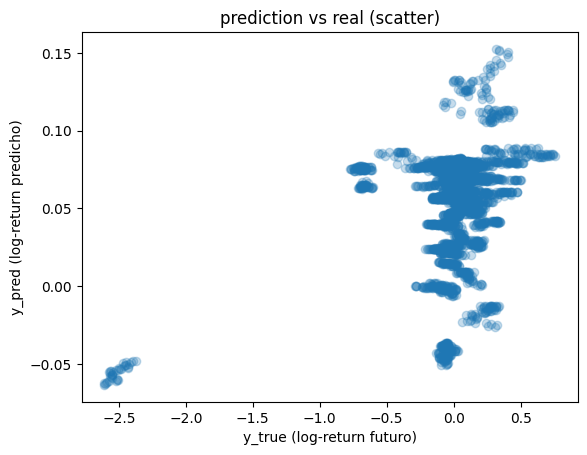

In [230]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(pred_df["y_true"], pred_df["y_pred"], alpha=0.25)
plt.xlabel("y_true (log-return futuro)")
plt.ylabel("y_pred (log-return predicho)")
plt.title("prediction vs real (scatter)")
plt.show()

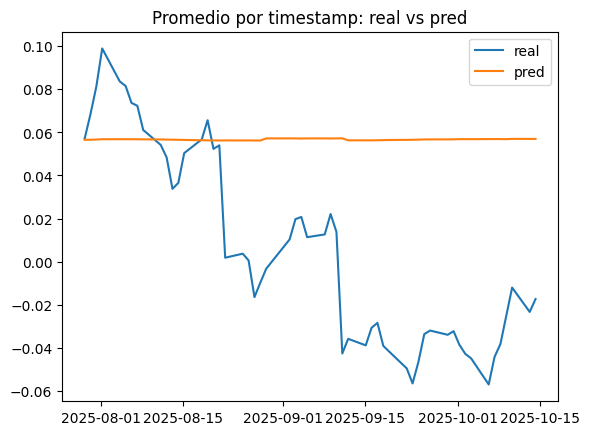

In [231]:
ts = (
    pred_df.groupby("timestamp")[["y_true", "y_pred"]]
    .mean()
    .sort_index()
)

plt.figure()
plt.plot(ts.index, ts["y_true"], label="real")
plt.plot(ts.index, ts["y_pred"], label="pred")
plt.title("Promedio por timestamp: real vs pred")
plt.legend()
plt.show()

# Not that useful in my opinion lol

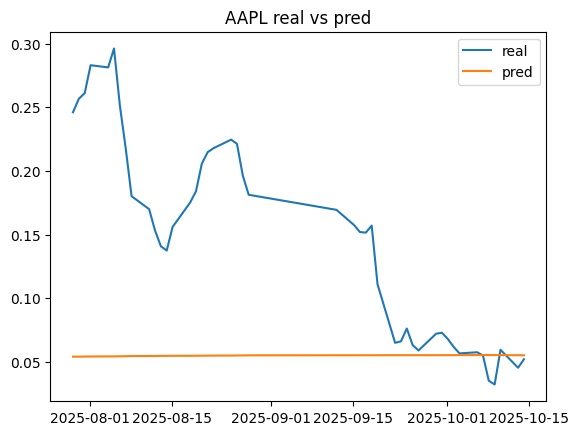

In [232]:
sym = pred_df["symbol"].iloc[0]
one = pred_df[pred_df["symbol"] == sym].sort_values("timestamp")

plt.figure()
plt.plot(one["timestamp"], one["y_true"], label="real")
plt.plot(one["timestamp"], one["y_pred"], label="pred")

plt.title(f"{sym} real vs pred")
plt.legend()
plt.show()


   bucket      mean  count
0       0 -0.212214    441
1       1  0.012905    440
2       2  0.070100    440
3       3  0.005701    440
4       4 -0.027014    440
5       5  0.077351    440
6       6  0.049408    440
7       7 -0.107812    440
8       8  0.023229    440
9       9  0.168877    440


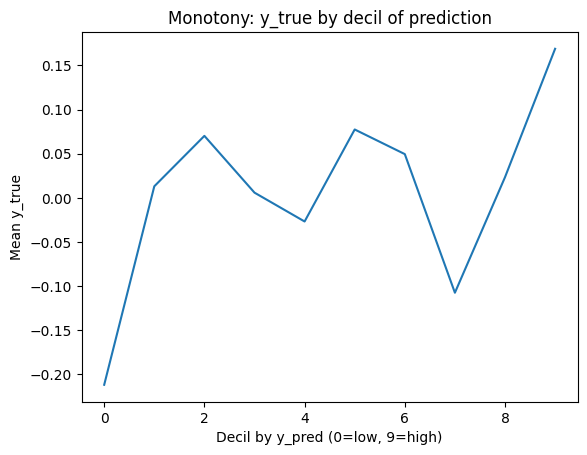

In [233]:
pred_df2 = pred_df.copy()
pred_df2["bucket"] = pd.qcut(pred_df2["y_pred"], 10, labels=False, duplicates = "drop")

bucket_stats = pred_df2.groupby("bucket")["y_true"].agg(["mean", "count"]).reset_index()
print(bucket_stats)
plt.figure()
plt.plot(bucket_stats["bucket"], bucket_stats["mean"])
plt.xlabel("Decil by y_pred (0=low, 9=high)")
plt.ylabel("Mean y_true")
plt.title("Monotony: y_true by decil of prediction")
plt.show()

In [234]:
# Precio actual ~ close_lag0
pred_df["close_t"] = X_test["close_lag0"].to_numpy(dtype=np.float64)

# Precio futuro predicho (por el modelo)
pred_df["close_pred_future"] = pred_df["close_t"] * np.exp(pred_df["y_pred"])

# Precio futuro real (usando y_true)
pred_df["close_true_future_from_y"] = pred_df["close_t"] * np.exp(pred_df["y_true"])

# Si quieres el close real desde df original (validación extra):
prices = df[["symbol", "timestamp", "close"]].copy()
prices["timestamp"] = pd.to_datetime(prices["timestamp"])
prices = prices.rename(columns={"timestamp": "target_timestamp", "close": "close_true_future_db"})

pred_df = pred_df.merge(prices, on=["symbol", "target_timestamp"], how="left")

pred_df[["symbol","timestamp","target_timestamp","close_t","close_pred_future","close_true_future_db"]].head()


,symbol,timestamp,target_timestamp,close_t,close_pred_future,close_true_future_db
0,AAPL,2025-07-29 04:00:00+00:00,2025-11-04 05:00:00+00:00,211.27,223.019063,270.21
1,ABBV,2025-07-29 04:00:00+00:00,2025-10-22 04:00:00+00:00,191.22,203.396416,228.68
2,ADBE,2025-07-29 04:00:00+00:00,2025-10-22 04:00:00+00:00,370.70,384.332125,354.09
3,AMAT,2025-07-29 04:00:00+00:00,2025-10-22 04:00:00+00:00,188.41,201.546465,220.56
4,AMD,2025-07-29 04:00:00+00:00,2025-10-22 04:00:00+00:00,177.44,197.411062,230.23


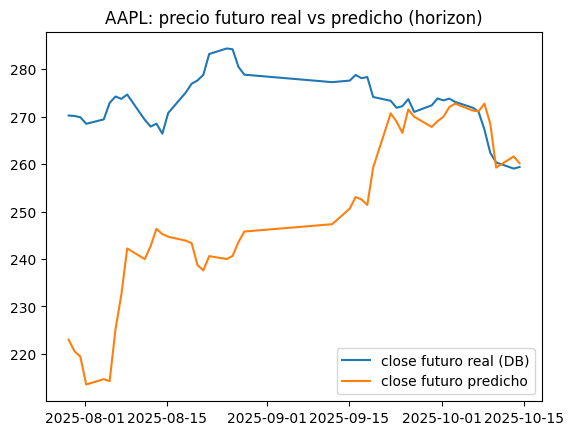

In [235]:
sym = pred_df["symbol"].iloc[0]
one = pred_df[pred_df["symbol"] == sym].sort_values("timestamp").dropna(subset=["close_true_future_db"])

plt.figure()
plt.plot(one["timestamp"], one["close_true_future_db"], label="close futuro real (DB)")
plt.plot(one["timestamp"], one["close_pred_future"], label="close futuro predicho")
plt.title(f"{sym}: precio futuro real vs predicho (horizon)")
plt.legend()
plt.show()


# Save artifact

In [236]:
ind_flag = int(include_indicators)
econ_flag = int(include_economic_indicators and econ_indicator_names is not None and len(econ_indicator_names) > 0)
fmp_flag = int(include_fmp)

run_dir = f"runs/ridge_{timeframe}_lb{lookback}_h{horizon}_indicators{ind_flag}_econ{econ_flag}_fmp{fmp_flag}"

config = {
    "model": "ridge",
    "timeframe": timeframe,
    "symbols": list(symbols),
    "lookback": lookback,
    "horizon": horizon,
    "base_feature_cols": base_feature_cols,
    "X_shape": [int(X.shape[0]), int(X.shape[1])],
    "trainval_rows": int(X_tv.shape[0]),
    "test_rows": int(X_test.shape[0]),
    "meta_time_min": str(pd.to_datetime(meta["timestamp"]).min()),
    "meta_time_max": str(pd.to_datetime(meta["timestamp"]).max()),
    "best_alpha": best_alpha,
    "cv_best_score_neg_mse": float(gs.best_score_),
    "include_indicators": bool(include_indicators),
    "include_econ": bool(include_economic_indicators),
    "econ_indicator_names": list(econ_indicator_names) if econ_indicator_names else [],
    "include_fmp": bool(include_fmp),
    "fmp_feature_names": list(fmp_feature_names) if fmp_feature_names else [],
    "fmp_prefix": fmp_prefix,
    "keep_fmp_asof_date": bool(keep_fmp_asof_date),
}

metrics = {
    "test": metrics_test,
    "best_alpha": best_alpha
}

save_ridge_artifact(
    run_dir=run_dir,
    pipeline=best_pipe,
    config=config,
    metrics=metrics, 
    feature_names=list(X.columns)
)

print(f"Saved to {run_dir}")


Saved to runs/ridge_1Day_lb120_h60_indicators0_econ0_fmp0
